In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from cm import plot_confusion_matrix

import warnings
%matplotlib inline 

warnings.filterwarnings('ignore')

#### First, read in all the dataframes. Cancer, HA, income, state_abbrev

In [2]:
# create ha_costs from mmd_heart_attack_data.csv
ha_costs = pd.read_csv('../data/mmd_heart_attack_data.csv')
ha_costs.head(2) # examine first rows of df

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,analysis_value
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,36615


In [3]:
# create cancer_costs_df from mmd_cancer_data.csv
cancer_costs = pd.read_csv('../data/mmd_cancer_data.csv')
cancer_costs.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,analysis_value
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,19293
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,17151


In [4]:
# read in income_df
income_df = pd.read_csv('../data/irs_county_2016.csv')
income_df.head(2)

,STATEFIPS,STATE,COUNTYFIPS,COUNTYNAME,agi_stub,N1,mars1,MARS2,MARS4,PREP,...,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902
0,1,AL,0,Alabama,1,26450,14680,9740,680,17780,...,4300,9256,70,57,0,0,2590,3685,11510,35079
1,1,AL,0,Alabama,2,285760,217880,25170,39740,143390,...,70050,40569,0,0,0,0,22720,11109,237630,263152


In [5]:
# read in the state_abbrev df
state_abbrev = pd.read_csv('../data/state_abbrev.csv')
state_abbrev.head(2)

,name,abbrev
0,ALABAMA,AL
1,ALASKA,AK


* #### Slice (select) the columns you want from the dataframes
* #### Rename necessary columns

In [6]:
cancer_costs = cancer_costs.rename(columns = {'analysis_value': 'cancer_avg_cost'})
cancer_costs.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,cancer_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,19293
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,"Cancer, Colorectal, Breast, Prostate, Lung",All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,17151


In [7]:
ha_costs = ha_costs.rename(columns = {'analysis_value': 'ha_avg_cost'})
ha_costs.head(2)

,year,geography,measure,adjustment,analysis,domain,condition,primary_sex,primary_age,primary_dual,fips,county,state,urban,primary_race,primary_denominator,ha_avg_cost
0,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1001,Autauga County,ALABAMA,Urban,All,undefined,40470
1,2017,County,Average total cost,Unsmoothed actual,Base measure,Primary chronic conditions,Acute myocardial infarction,All,All,Dual & non-dual,1003,Baldwin County,ALABAMA,Rural,All,undefined,36615


In [8]:
# select/slice only the columns we want from income_df
income_df = income_df[['STATE', 'COUNTYNAME', 'agi_stub', 'N1', 'mars1',
                       'MARS2', 'MARS4', 'N2', 'NUMDEP', 'ELDERLY', 'A00100', 'N02650', 
                       'A02650', 'N02300', 'A02300']]
# rename columns
income_df.columns = ['state', 'county', 'income_bucket', 
                     'return_count', 'single_returns', 'joint_returns', 
                     'head_of_house_returns', 'exemptions', 'dependents', 
                     'elderly', 'agi', 'returns_with_total_inc','total_inc_amt', 
                     'returns_with_unemployment', 'unemployment_comp']
income_df.head(2)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,AL,Alabama,1,26450,14680,9740,680,40700,5590,13000,-1679314,19140,-1657452,60,203
1,AL,Alabama,2,285760,217880,25170,39740,296830,78450,48270,1582247,285760,1632624,4180,10772


In [9]:
# slice the columns you want from the cancer_costs df
cancer_costs = cancer_costs[['state', 'county', 'urban', 'cancer_avg_cost']]
cancer_costs.head(2)

,state,county,urban,cancer_avg_cost
0,ALABAMA,Autauga County,Urban,19293
1,ALABAMA,Baldwin County,Rural,17151


In [10]:
# slice the columns you want from ha_costs df
ha_costs = ha_costs[['state', 'county', 'urban', 'ha_avg_cost']]
ha_costs.head(2)

,state,county,urban,ha_avg_cost
0,ALABAMA,Autauga County,Urban,40470
1,ALABAMA,Baldwin County,Rural,36615


#### `Groupby` both state and county in income_df

In [11]:
# groupby state and column
income_agg = income_df.groupby(['state', 'county']).agg('sum')
income_agg.head(2)

income_bucket  return_count  single_returns  \
state county                                                              
AK    Alaska                           36        348070          175480   
      Aleutians East Borou             36           890             480   

                            joint_returns  head_of_house_returns  exemptions  \
state county                                                                   
AK    Alaska                       126660                  37340      654950   
      Aleutians East Borou            230                    150        1570   

                            dependents  elderly       agi  \
state county                                                
AK    Alaska                    205660    71410  23514361   
      Aleutians East Borou         500      160     42834   

                            returns_with_total_inc  total_inc_amt  \
state county                                                        
AK    Alaska                                347600       23858011   
      Aleutians East Borou                     890          43596   

                            returns_with_unemployment  unemployment_comp  
state county                                                              
AK    Alaska                                    83270             167460  
      Aleutians East Borou                        190                466

In [12]:
# reset index of income_agg
income_agg = income_agg.reset_index()
income_agg.head(2)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460
1,AK,Aleutians East Borou,36,890,480,230,150,1570,500,160,42834,890,43596,190,466


#### Create avg income column in income_agg df

In [13]:
income_agg['approx_avg_income'] = round(1000 * income_agg['total_inc_amt']/income_agg['returns_with_total_inc'], 0)
income_agg.head(2)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp,approx_avg_income
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460,68636.0
1,AK,Aleutians East Borou,36,890,480,230,150,1570,500,160,42834,890,43596,190,466,48984.0


#### Map the state_abbrev to cancer and ha dfs

In [14]:
state_abbrev = pd.read_csv('../data/state_abbrev.csv')
state_abbrev.head(2)

,name,abbrev
0,ALABAMA,AL
1,ALASKA,AK


In [15]:
# creates a dictionary of the columns in df
state_abbrev.set_index('name')['abbrev'].to_dict()

{'ALABAMA': 'AL',
 'ALASKA': 'AK',
 'ARIZONA': 'AZ',
 'ARKANSAS': 'AR',
 'CALIFORNIA': 'CA',
 'COLORADO': 'CO',
 'CONNECTICUT': 'CT',
 'DELAWARE': 'DE',
 'DISTRICT OF COLUMBIA': 'DC',
 'FLORIDA': 'FL',
 'GEORGIA': 'GA',
 'HAWAII': 'HI',
 'IDAHO': 'ID',
 'ILLINOIS': 'IL',
 'INDIANA': 'IN',
 'IOWA': 'IA',
 'KANSAS': 'KS',
 'KENTUCKY': 'KY',
 'LOUISIANA': 'LA',
 'MAINE': 'ME',
 'MARYLAND': 'MD',
 'MASSACHUSETTS': 'MA',
 'MICHIGAN': 'MI',
 'MINNESOTA': 'MN',
 'MISSISSIPPI': 'MS',
 'MISSOURI': 'MO',
 'MONTANA': 'MT',
 'NEBRASKA': 'NE',
 'NEVADA': 'NV',
 'NEW HAMPSHIRE': 'NH',
 'NEW JERSEY': 'NJ',
 'NEW MEXICO': 'NM',
 'NEW YORK': 'NY',
 'NORTH CAROLINA': 'NC',
 'NORTH DAKOTA': 'ND',
 'OHIO': 'OH',
 'OKLAHOMA': 'OK',
 'OREGON': 'OR',
 'PENNSYLVANIA': 'PA',
 'RHODE ISLAND': 'RI',
 'SOUTH CAROLINA': 'SC',
 'SOUTH DAKOTA': 'SD',
 'TENNESSEE': 'TN',
 'TEXAS': 'TX',
 'UTAH': 'UT',
 'VERMONT': 'VT',
 'VIRGINIA': 'VA',
 'WASHINGTON': 'WA',
 'WEST VIRGINIA': 'WV',
 'WISCONSIN': 'WI',
 'WYOMING': 'WY

In [16]:
# maps the stat_abbrev dict to the 'state' column of cancer_costs df
cancer_costs['state'] = cancer_costs['state'].map(state_abbrev.set_index('name')['abbrev'].to_dict())
cancer_costs.head(2)

,state,county,urban,cancer_avg_cost
0,AL,Autauga County,Urban,19293
1,AL,Baldwin County,Rural,17151


In [17]:
# maps the stat_abbrev dict to the 'state' column of cancer_costs df
ha_costs['state']=ha_costs.state.map(state_abbrev.set_index('name')['abbrev'].to_dict())
ha_costs.head()

,state,county,urban,ha_avg_cost
0,AL,Autauga County,Urban,40470
1,AL,Baldwin County,Rural,36615
2,AL,Barbour County,Rural,46509
3,AL,Bibb County,Urban,42949
4,AL,Blount County,Urban,50067


#### Merge income_agg df with cancer_costs df

In [18]:
cancer_costs.head(2)

,state,county,urban,cancer_avg_cost
0,AL,Autauga County,Urban,19293
1,AL,Baldwin County,Rural,17151


In [19]:
income_agg.head(2)

,state,county,income_bucket,return_count,single_returns,joint_returns,head_of_house_returns,exemptions,dependents,elderly,agi,returns_with_total_inc,total_inc_amt,returns_with_unemployment,unemployment_comp,approx_avg_income
0,AK,Alaska,36,348070,175480,126660,37340,654950,205660,71410,23514361,347600,23858011,83270,167460,68636.0
1,AK,Aleutians East Borou,36,890,480,230,150,1570,500,160,42834,890,43596,190,466,48984.0


In [20]:
merged_df = pd.merge(cancer_costs, income_agg[['state','county', 'approx_avg_income']], on = ['state', 'county'], how = 'inner')
merged_df.head(2)

,state,county,urban,cancer_avg_cost,approx_avg_income
0,AL,Autauga County,Urban,19293,55843.0
1,AL,Baldwin County,Rural,17151,62832.0


### What is our target variable? What are the predictor variables?
- The target is whether or not `cancer_avg_cost` is above or below the mean.
- Currently, the only predictor we have is urban/rural.

In [21]:
# create cancer_cost_ratio column from cancer_avg_cost and approx_avg_income in merged_df
merged_df['cancer_cost_ratio'] = merged_df['cancer_avg_cost'] / merged_df['approx_avg_income']
merged_df.head(2)

,state,county,urban,cancer_avg_cost,approx_avg_income,cancer_cost_ratio
0,AL,Autauga County,Urban,19293,55843.0,0.345486
1,AL,Baldwin County,Rural,17151,62832.0,0.272966


In [22]:
# use .describe() to identify the mean and stats of the cancer_cost_ratio column
merged_df.cancer_cost_ratio.describe()

count    3066.000000
mean        0.414977
std         0.120398
min         0.065843
25%         0.335343
50%         0.407073
75%         0.480998
max         1.317388
Name: cancer_cost_ratio, dtype: float64

In [23]:
# set avg_cancer_ratio variable to mean of cancer_cost_ratio in merged_df
avg_cancer_ratio = merged_df.cancer_cost_ratio.mean()
avg_cancer_ratio

0.4149767494462439

In [24]:
# set the condition for the predictive model
# want to see if cancer_avg_cost is above or below the mean
merged_df['above_avg_cancer_ratio'] = merged_df['cancer_cost_ratio'] > avg_cancer_ratio
merged_df.head()

,state,county,urban,cancer_avg_cost,approx_avg_income,cancer_cost_ratio,above_avg_cancer_ratio
0,AL,Autauga County,Urban,19293,55843.0,0.345486,False
1,AL,Baldwin County,Rural,17151,62832.0,0.272966,False
2,AL,Barbour County,Rural,19469,40269.0,0.483474,True
3,AL,Bibb County,Urban,17234,47380.0,0.363740,False
4,AL,Blount County,Urban,20317,49535.0,0.410154,False


#### Encode the urban/rural column using `get_dummies`

In [25]:
merged_df_dummies = pd.get_dummies(merged_df, columns = ['urban'], drop_first = True)
merged_df_dummies.head(3)

,state,county,cancer_avg_cost,approx_avg_income,cancer_cost_ratio,above_avg_cancer_ratio,urban_Urban
0,AL,Autauga County,19293,55843.0,0.345486,False,1
1,AL,Baldwin County,17151,62832.0,0.272966,False,0
2,AL,Barbour County,19469,40269.0,0.483474,True,0


In [26]:
merged_df_dummies.shape

(3066, 7)

#### Use only urban/rural to predict

In [27]:
# Predictors
X = merged_df_dummies[['urban_Urban']]
# Target
y = merged_df_dummies.above_avg_cancer_ratio

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2020)

In [29]:
logistic_model = LogisticRegression()

In [30]:
logistic_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

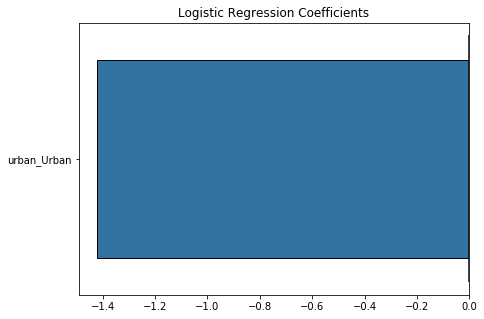

In [31]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients')

ymin, ymax = plt.ylim()
plt.vlines(x = 0, ymin = ymin, ymax = ymax);

Looks like a county being urban decreases the chances that the cost ratio will be above aveage.

In [32]:
y_pred = logistic_model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6544980443285529


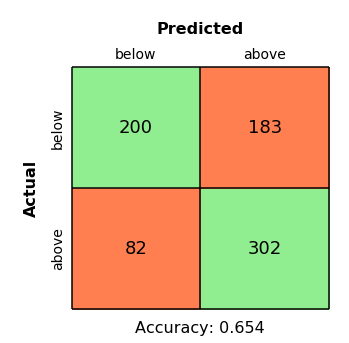

In [33]:
plot_confusion_matrix(y_test, y_pred, labels = ['below', 'above'], metric = 'accuracy')

In [34]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.71      0.52      0.60       383
        True       0.62      0.79      0.70       384

    accuracy                           0.65       767
   macro avg       0.67      0.65      0.65       767
weighted avg       0.67      0.65      0.65       767



In [35]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]

print(metrics.roc_auc_score(y_test, y_pred_prob))

0.654325772410792


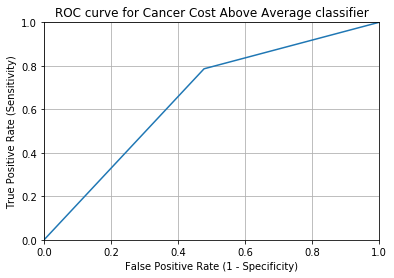

In [36]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Cost Above Average classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

 #### Incorporate some of the geographic profile data

In [37]:
geographic_info = pd.read_csv('../data/geographic_profile.csv')
geographic_info.head()

,state,county,Median Household Income (5y Average),Median Household Income for +7-person Households (5y Avg.),Median Household Income for 1-person Households (5y Avg.),Median Household Income for 2-person Households (5y Avg.),Median Household Income for 3-person Households (5y Avg.),Median Household Income for 4-person Households (5y Avg.),Median Household Income for 5-person Households (5y Avg.),Median Household Income for 6-person Households (5y Avg.),...,Percent of 3 Person Households with 3 Workers (5y Avg.),Percent of 3 Person Households with No Workers (5y Avg.),Percent of Senior Population Below Federal Poverty Level (1y Avg.),Percent of Senior Population Below Federal Poverty Level (5y Avg.),Percentage of Total Housing Units that are Vacant (1y Avg.),Percentage of Total Housing Units that are Vacant (5y Avg.),Senior Unemployment Rate (1y Avg.),Senior Unemployment Rate (5y Avg.),Unemployment Rate (1y Avg.),Unemployment Rate (5y Avg.)
0,AL,Autauga County,53099.0,104659.0,26834.0,58452.0,76406.0,74429.0,73017.0,81500.0,...,0.101183,0.106110,NaN,0.061893,NaN,0.083869,NaN,0.079755,NaN,0.055252
1,AL,Baldwin County,51365.0,86250.0,26010.0,59570.0,68369.0,79153.0,69484.0,67693.0,...,0.124101,0.129932,0.077699,0.069984,0.293833,0.274180,0.032243,0.037965,0.035886,0.062713
2,AL,Barbour County,33956.0,NaN,16450.0,42631.0,42429.0,44563.0,46563.0,48250.0,...,0.093651,0.226190,NaN,0.162366,NaN,0.221912,NaN,0.083538,NaN,0.128247
3,AL,Bibb County,39776.0,111477.0,19127.0,41183.0,43520.0,51760.0,68375.0,76579.0,...,0.110305,0.206096,NaN,0.106445,NaN,0.214445,NaN,0.036667,NaN,0.071429
4,AL,Blount County,46212.0,50723.0,22171.0,50601.0,60406.0,64705.0,54390.0,48913.0,...,0.043669,0.186762,NaN,0.098941,NaN,0.132788,NaN,0.049601,NaN,0.059515


In [38]:
geographic_info.isna().sum()
# identify how many missing items in specific columns to choose usable predictors

state                                                                    0
county                                                                   0
Median Household Income (5y Average)                                     0
Median Household Income for +7-person Households (5y Avg.)             777
Median Household Income for 1-person Households (5y Avg.)                0
Median Household Income for 2-person Households (5y Avg.)                1
Median Household Income for 3-person Households (5y Avg.)               19
Median Household Income for 4-person Households (5y Avg.)               39
Median Household Income for 5-person Households (5y Avg.)              125
Median Household Income for 6-person Households (5y Avg.)              455
Percent Below Federal Poverty Level (1y Avg.)                         2389
Percent Below Federal Poverty Level (5y Avg.)                            0
Percent of +4 Person Households with +3 Workers (5y Avg.)                0
Percent of +4 Person Hous

In [39]:
geographic_info = geographic_info[['state', 'county', 'Percent Below Federal Poverty Level (5y Avg.)']]
geographic_info.head(2)

,state,county,Percent Below Federal Poverty Level (5y Avg.)
0,AL,Autauga County,0.122660
1,AL,Baldwin County,0.129938


In [40]:
merged_df_dummies = pd.merge(left = merged_df_dummies, right = geographic_info)

In [41]:
merged_df_dummies.head()

,state,county,cancer_avg_cost,approx_avg_income,cancer_cost_ratio,above_avg_cancer_ratio,urban_Urban,Percent Below Federal Poverty Level (5y Avg.)
0,AL,Autauga County,19293,55843.0,0.345486,False,1,0.122660
1,AL,Baldwin County,17151,62832.0,0.272966,False,0,0.129938
2,AL,Barbour County,19469,40269.0,0.483474,True,0,0.263737
3,AL,Bibb County,17234,47380.0,0.363740,False,1,0.164539
4,AL,Blount County,20317,49535.0,0.410154,False,1,0.165344


In [42]:
X = merged_df_dummies[['urban_Urban', 'Percent Below Federal Poverty Level (5y Avg.)']]
y = merged_df_dummies.above_avg_cancer_ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2020)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

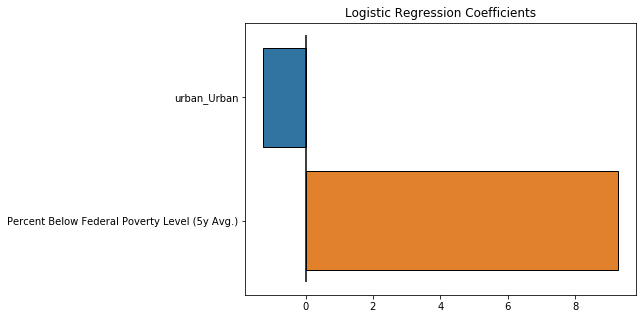

In [43]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients')
ymin, ymax = plt.ylim()
plt.vlines(x = 0, ymin = ymin, ymax = ymax);

In [44]:
y_pred = logistic_model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7405475880052151


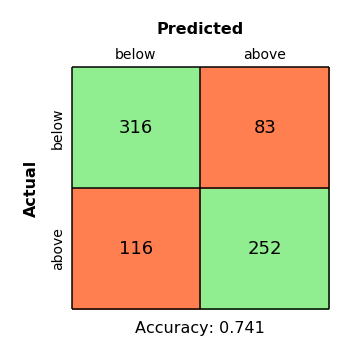

In [45]:
plot_confusion_matrix(y_test, y_pred, labels = ['below', 'above'], metric = 'accuracy')

In [46]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]

print(metrics.roc_auc_score(y_test, y_pred_prob))

0.8011536994660565


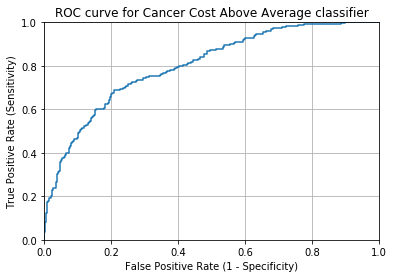

In [47]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Cost Above Average classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### build and evaluate a `RandomForestClassifier`

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#import graphviz
from IPython.display import SVG

In [49]:
forest = RandomForestClassifier(n_estimators = 1000, max_depth = 5, min_samples_leaf = 5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [50]:
y_pred_train = forest.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))

0.7310704960835509


In [51]:
y_pred = forest.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
# lower gap between trainin prediction and test prediction, so more accurate

0.741851368970013


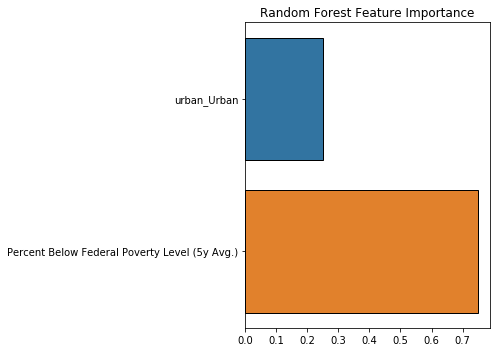

In [52]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = forest.feature_importances_, y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig('../assets/random_forest_feature_importance.png', dpi = 300);

In [53]:
plt.savefig('../assets/random_forest_feature_importance.png', dpi = 300);

<Figure size 432x288 with 0 Axes>